Slow version of gensim.models.doc2vec is being used
/home/ec2-user/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Number of relevant pixels =  209


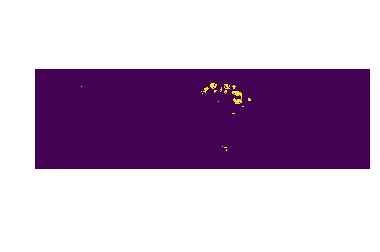

In [1]:
# OUTPUTS IONS WITH MOST DIFFERENT INTENSITY VALUES IN A REGION 

# SET SUMFORMULA NAME, ADDUCT, DATASET for selecting the region
sf = 'C26H45NO7S'
adduct = '+Na'
ds_name = 'wb xenograft in situ metabolomics test - rms_corrected'

# model param : tfidf or lsi or corpus
model = "tfidf"
# quantile param
q = 95.
# fdr threshold
t = 50

import os
from os import path
import pandas as pd
import gensim
from gensim import corpora
import pickle
import numpy as np

base_path = '/opt/data/'
ann_path = path.join(base_path, 'pixel-annot-export')
cor_path = path.join(base_path, 'pixel-corpora/pixel_'+model+'.mm')
map_path = path.join(base_path, 'pixel-ind2ord')

ds_df_path = path.join(ann_path, 'ds_df.msgpack')
ds_df = pd.read_msgpack(ds_df_path)
ds_ind = ds_df[ds_df['name'] == ds_name].index.tolist()[0]

ion_df_path = path.join(ann_path, 'ion_df.msgpack')
ion_df = pd.read_msgpack(ion_df_path)
ion_ind = ion_df[ion_df.formula == sf][ion_df.adduct == adduct].index.tolist()[0]

pind2ord_path = path.join(map_path, '{}.pkl'.format(ds_ind))
with open(pind2ord_path, 'rb') as f: pind2ord = pickle.load(f)

pixel_df_path = path.join(ann_path, 'pixel_df_list/{}.msgpack'.format(ds_ind))
pixel_df = pd.read_msgpack(pixel_df_path)

int = np.percentile(pixel_df.int.tolist(), q)
ion_sub_df = pixel_df[(pixel_df.ion_ind == ion_ind) & (pixel_df.int > int)]
ion_unique_pix = ion_sub_df.p_ind.unique()
region_pixel_ids = [pind2ord[i] for i in ion_unique_pix if i in pind2ord]

print('Number of relevant pixels = ', len(region_pixel_ids))

%matplotlib inline
import matplotlib.pyplot as plt

max_x = pixel_df['x'].max()
max_y = pixel_df['y'].max()
arr = np.zeros([max_x+1, max_y+1])

for index, row in ion_sub_df.iterrows():
    arr[row['x'].astype(np.int64)][row['y'].astype(np.int64)] = 1
arr = np.rot90(arr, 1)

plt.pcolormesh(arr,cmap='viridis')
plt.axes().set_aspect('equal', 'datalim')
plt.axes().axis('off')
plt.show()

In [3]:
import gensim
from gensim import corpora
from gensim import models

extra_region_pixel_ids = [pind2ord[i] for i in pixel_df.p_ind.unique() if i not in ion_unique_pix and i in pind2ord]

corpus = gensim.corpora.MmCorpus(cor_path)

def average4region(pixel_ids, corpus):
    ions2values = {}
    for pix_id in pixel_ids:
        for (ion_id,value) in corpus[pix_id]:
            if not ion_id in ions2values: ions2values[ion_id] = []
            ions2values[ion_id].append(value)

    average = {}
    for ion_id in ions2values:
        average[ion_id] = np.mean(ions2values[ion_id])
    return average

region_average = average4region(region_pixel_ids, corpus)
extra_region_average = average4region(extra_region_pixel_ids, corpus)

diff_cor = []
for ion_id in region_average:
    if ion_id in extra_region_average:
        diff_cor.append((ion_id,region_average[ion_id]/extra_region_average[ion_id]))
    else:
        diff_cor.append((ion_id,region_average[ion_id])/1e-10)
        
diff_cor.sort(key=lambda x: x[1],reverse=True)

In [4]:
def hotspot_removal(img):
    perc99_v = np.percentile(img, q=99.9)
    img[img > perc99_v] = perc99_v
    return img

C31H33N3O7S +H: 11.909489


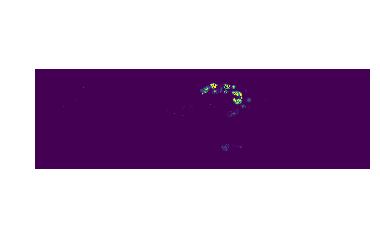

C6H14N4O2 +H: 7.632652


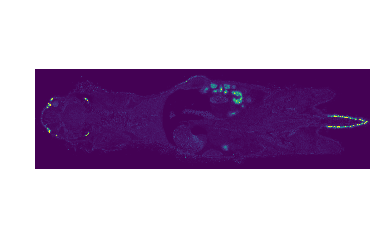

C12H24N4O7 +H: 6.630415


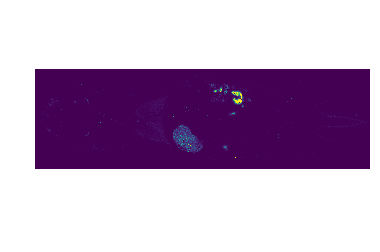

C26H45NO7S +Na: 6.621750


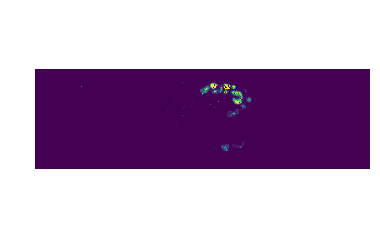

C12H20N2O7 +H: 6.114197


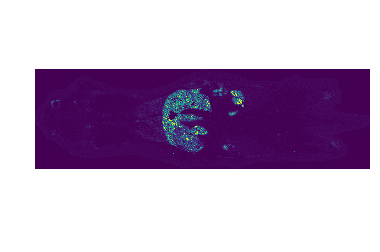

C26H45NO7S +K: 4.785819


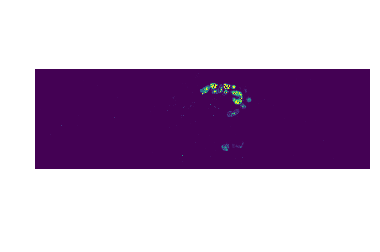

C12H20N2O3 +H: 3.672047


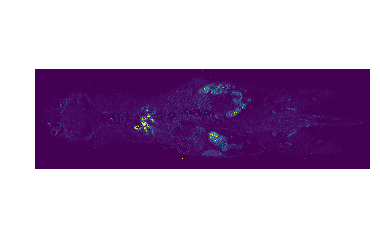

C11H9NO2 +H: 3.352829


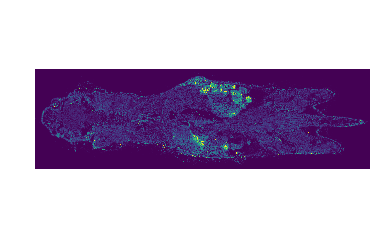

C37H66O4 +H: 2.979025


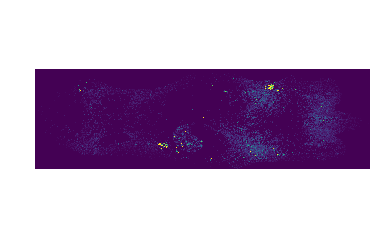

C25H32O10 +H: 2.793913


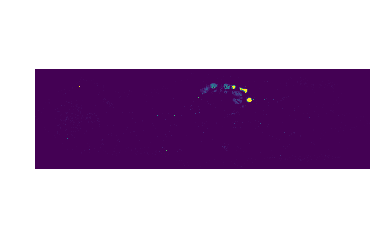

C14H17N5O8 +H: 2.709453


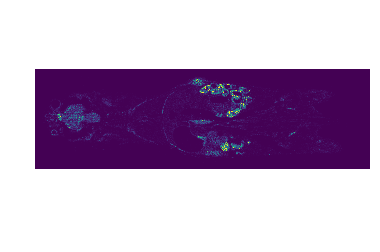

C12H24N2O3 +H: 2.508163


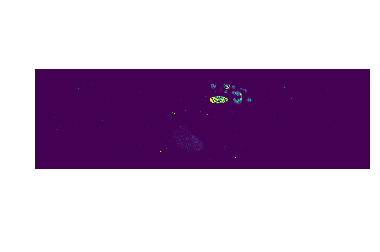

C27H40O8 +H: 2.406157


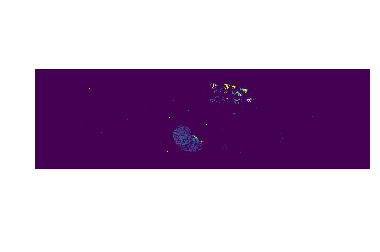

C21H21NO6 +Na: 2.274073


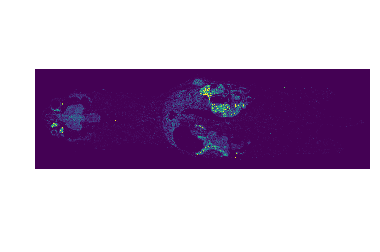

C16H21N3O2 +H: 2.201548


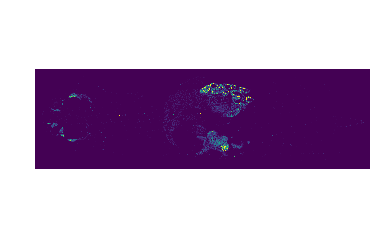

C27H32O5 +K: 2.175700


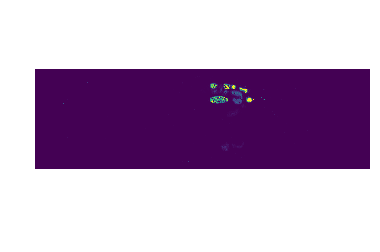

C9H11NO3 +H: 2.175623


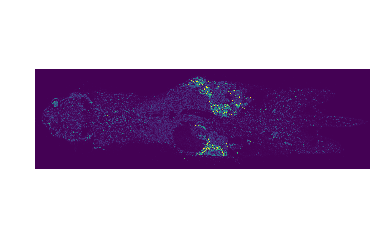

C9H8O3 +H: 2.140233


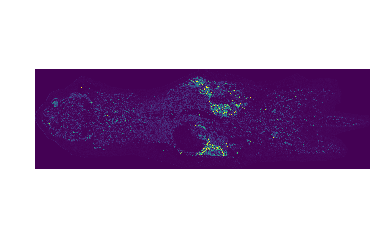

C31H42O2 +H: 1.883966


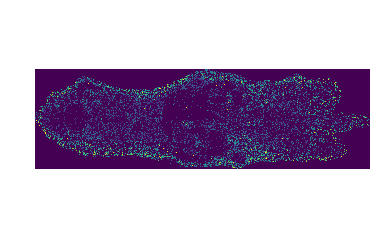

C25H47NO4 +H: 1.870439


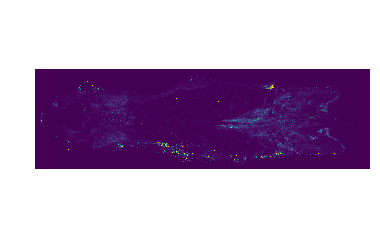

C8H20NO6P +H: 1.748261


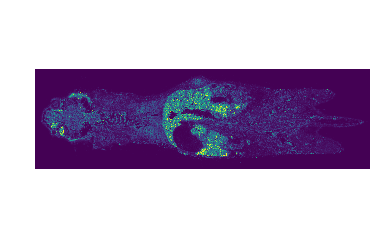

C13H17NO3 +Na: 1.747332


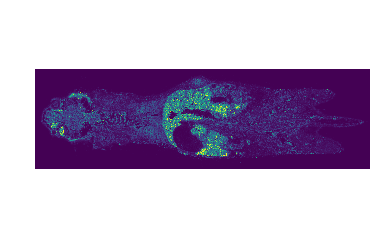

C11H12N2O +H: 1.744982


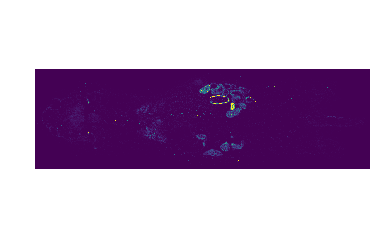

C18H32O16 +Na: 1.739757


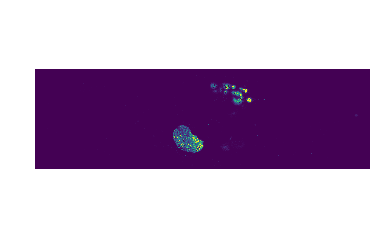

C5H4N4O +Na: 1.722837


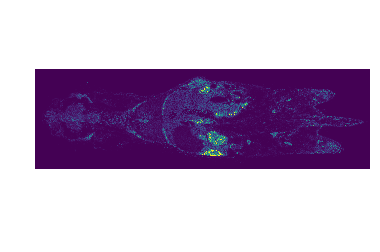

C24H29NO9 +H: 1.644033


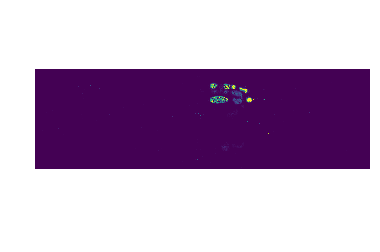

C7H7NO2 +Na: 1.596429


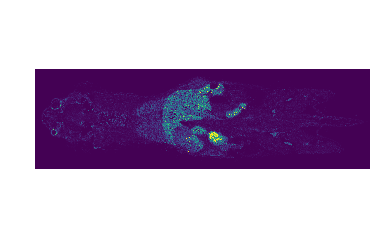

C10H9NO +H: 1.585032


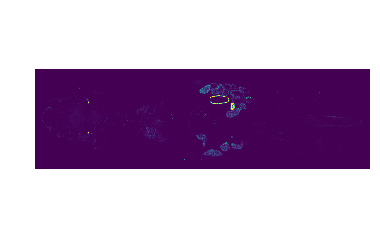

C9H20N2O2 +H: 1.518669


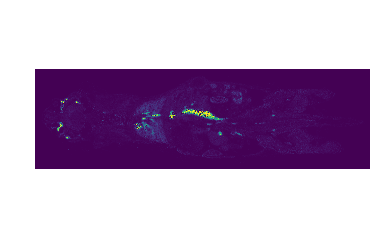

C16H18N6O5 +Na: 1.472187


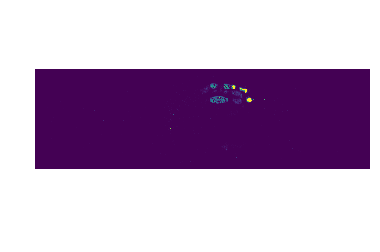

C6H12O6 +Na: 1.414196


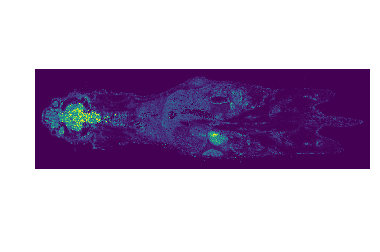

C15H15NO3 +H: 1.403554


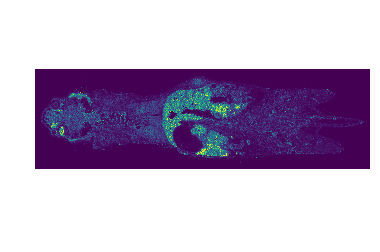

C23H44NO7P +H: 1.400121


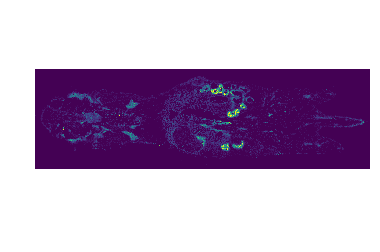

C35H66O4 +H: 1.318298


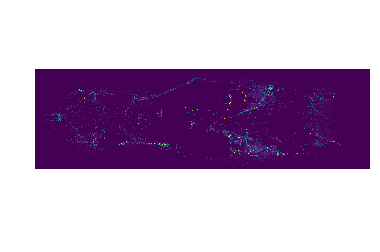

C10H26N4 +H: 1.311019


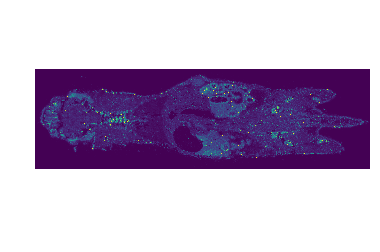

C15H23N3O3 +H: 1.292409


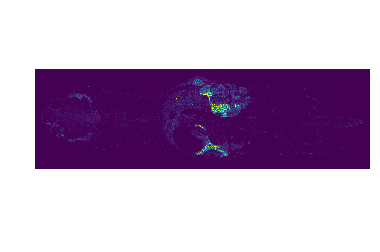

C24H50NO6P +H: 1.161765


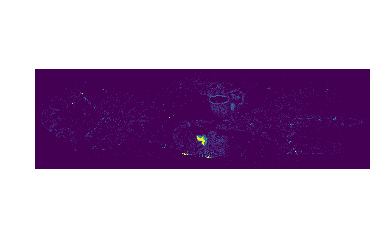

C14H18N2O +H: 1.159119


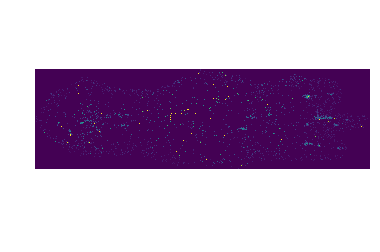

C19H27NO3 +H: 1.153814


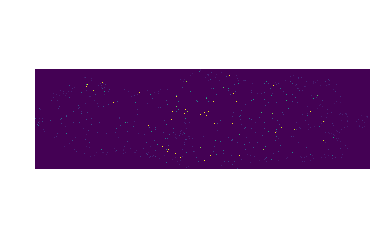

C18H23NO4 +H: 1.151678


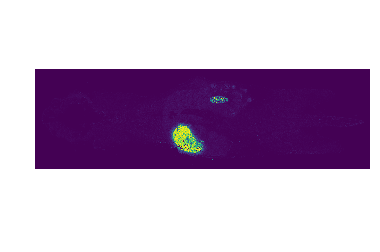

In [5]:
# THRESHOLD FOR MOST CHARACTRISTIC IONS
ch = 0.0000005
# NUMBER OF MOST CHARACTRISTIC IONS
n = 40

counter = 0
csv_ions = []
for (ion_ind,value) in diff_cor:
    if counter == n or value<ch: break
    counter+=1
    print('%s %s: %f' % (ion_df.at[ion_ind,'formula'], ion_df.at[ion_ind,'adduct'], value))
    csv_ions.append('%s,%s,%f' % (ion_df.at[ion_ind,'formula'], ion_df.at[ion_ind,'adduct'], value))

    ion_sub_df = pixel_df[pixel_df.ion_ind == ion_ind]
    
    max_x = pixel_df['x'].max()
    max_y = pixel_df['y'].max()
    arr = np.zeros([max_x+1, max_y+1])

    for index, row in ion_sub_df.iterrows():
        arr[row['x'].astype(np.int64)][row['y'].astype(np.int64)] = row['int']
        
    arr = np.rot90(arr, 1)
    arr = hotspot_removal(arr)
    plt.pcolormesh(arr,cmap='viridis')
    plt.axes().set_aspect('equal', 'datalim')
    plt.axes().axis('off')
    plt.show()

In [97]:
for e in csv_ions: print(e)

C31H33N3O7S,+H,11.909489
C6H14N4O2,+H,7.632652
C12H24N4O7,+H,6.630415
C26H45NO7S,+Na,6.621750
C12H20N2O7,+H,6.114197
C26H45NO7S,+K,4.785819
C12H20N2O3,+H,3.672047
C11H9NO2,+H,3.352829
C37H66O4,+H,2.979025
C25H32O10,+H,2.793913
C14H17N5O8,+H,2.709453
C12H24N2O3,+H,2.508163
C27H40O8,+H,2.406157
C21H21NO6,+Na,2.274073
C16H21N3O2,+H,2.201548
C27H32O5,+K,2.175700
C9H11NO3,+H,2.175623
C9H8O3,+H,2.140233
C31H42O2,+H,1.883966
C25H47NO4,+H,1.870439
C8H20NO6P,+H,1.748261
C13H17NO3,+Na,1.747332
C11H12N2O,+H,1.744982
C18H32O16,+Na,1.739757
C5H4N4O,+Na,1.722837
C24H29NO9,+H,1.644033
C7H7NO2,+Na,1.596429
C10H9NO,+H,1.585032
C9H20N2O2,+H,1.518669
C16H18N6O5,+Na,1.472187
C6H12O6,+Na,1.414196
C15H15NO3,+H,1.403554
C23H44NO7P,+H,1.400121
C35H66O4,+H,1.318298
C10H26N4,+H,1.311019
C15H23N3O3,+H,1.292409
C24H50NO6P,+H,1.161765
C14H18N2O,+H,1.159119
C19H27NO3,+H,1.153814
C18H23NO4,+H,1.151678
